<a href="https://colab.research.google.com/github/AmanPriyanshu/Federated-Learning/blob/main/Trials_With_Federated_Learning_Sine_Curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TRIALS WITH FEDERATED - LEARNING SINE CURVE:

## IMPORTS:

In [1]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

import logging
tf.get_logger().setLevel(logging.ERROR)
from matplotlib import pyplot as plt

## GENERATING DATASET:

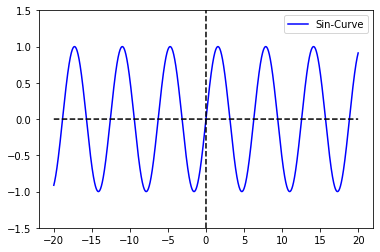

In [2]:
x = np.arange(-10000, 10000)/500
y = np.sin(x)

plt.plot(x, y, color='blue', label='Sin-Curve')
plt.ylim([-1.5, 1.5])
plt.plot(x, y*0, '--', color='black')
plt.plot(x*0, x/13.3, '--', color='black')
plt.legend()
plt.show()

In [3]:
def dataset_generator(n=1000, x_range=[-10, 10]):
  x = np.random.uniform(x_range[0], x_range[1], n//50)
  y = np.array([i/25 for i in range(-25, 25)])
  data = []
  for i in x:
    for j in y:
      data.append([i, j])
  data = np.array(data)
  labels = np.array([0.0 if i[1]>np.sin(i[0]) else 1.0 for i in data])
  return data, labels

In [4]:
number_of_samples = 10000

In [5]:
x, y = dataset_generator(number_of_samples)

In [6]:
def the_curve_generated_so_far(model):
  x_plot, y_plot = [], []
  for x in range(-200, 200, 10):
    x = x/10
    y = [i/25 for i in range(-25, 25)]
    y_pred = model.predict([[[x, i] for i in y]])
    y_pred = np.abs(y_pred.flatten() - 0.5)
    points_of_interest = [y[k] for k in [i for i in range(1, len(y_pred)-1, 1) if y_pred[i]<y_pred[i+1] and y_pred[i]<y_pred[i-1]]]
    x_plot.append(x)
    if len(points_of_interest)>0:
      y_plot.append(points_of_interest[0])
    else:
      y_plot.append(0)
  x_plot = np.array(x_plot)
  y_plot = np.array(y_plot)
  plt.plot(x_plot, y_plot, color='blue', label='Sin-Curve')
  plt.ylim([-1.5, 1.5])
  plt.plot(x_plot, y_plot*0, '--', color='black')
  plt.plot(x_plot*0, x_plot/13.3, '--', color='black')
  plt.legend()
  plt.show()

# NORMAL:

In [7]:
model = tf.keras.models.Sequential([
                                   tf.keras.layers.Input((2, )),
                                   tf.keras.layers.Dense(16, activation="relu"),
                                   tf.keras.layers.Dense(32, activation="swish"),
                                   tf.keras.layers.Dense(32, activation="swish"),
                                   tf.keras.layers.Dense(16, activation="relu"),
                                   tf.keras.layers.Dense(8, activation="swish"),
                                   tf.keras.layers.Dense(1, activation='sigmoid'),
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
history = model.fit(x, y, epochs=150, validation_split=0.1, verbose=0)
model.evaluate(x, y)

313/313 [==============================] - 0s 882us/step - loss: 0.0415 - acc: 0.9800


[0.041466016322374344, 0.9800000190734863]

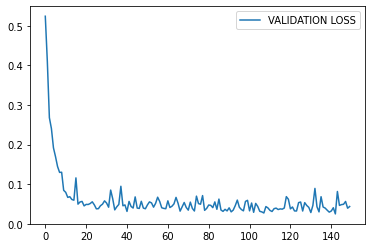

In [8]:
plt.plot(history.history['val_loss'], label='VALIDATION LOSS')
plt.legend()
plt.show()

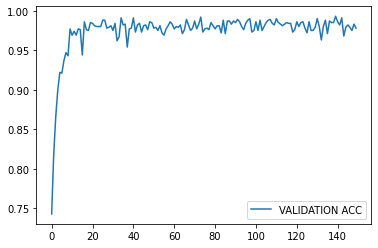

In [9]:
plt.plot(history.history['val_acc'], label='VALIDATION ACC')
plt.legend()
plt.show()

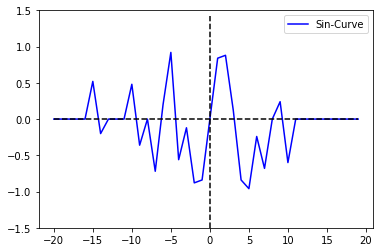

In [10]:
the_curve_generated_so_far(model)

# IID:

## Defining Client Side Model:

In [11]:
def generate_client_side_model(initial_weights=None):
  client_model = tf.keras.models.Sequential([
                                   tf.keras.layers.Input((2, )),
                                   tf.keras.layers.Dense(16, activation="relu"),
                                   tf.keras.layers.Dense(32, activation="swish"),
                                   tf.keras.layers.Dense(32, activation="swish"),
                                   tf.keras.layers.Dense(16, activation="relu"),
                                   tf.keras.layers.Dense(8, activation="swish"),
                                   tf.keras.layers.Dense(1, activation='sigmoid'),
  ])

  client_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

  if initial_weights!=None:
    client_model.set_weights(initial_weights)

  return client_model

## Aggregator Model:

In [12]:
def generate_aggregator_model():
  aggregator_model = generate_client_side_model()
  w = aggregator_model.get_weights()
  w = [0*i for i in w]
  aggregator_model.set_weights(w)
  return aggregator_model

## IID Attempt:

In [13]:
number_of_clients = 5
aggregator_epochs = 30
client_epochs = 5

number_of_sample_per_client = number_of_samples//number_of_clients

In [14]:
def iid_generator(number_of_clients, x, y):
  clients = {i:[] for i in range(number_of_clients)}

  indexes = np.arange(x.shape[0])
  for client in clients.keys():
    clients[client] = np.random.choice(indexes, number_of_sample_per_client, replace=False)
    indexes = np.array([i for i in indexes if i not in clients[client]])

  clients_dataset = {}
  for client in clients.keys():
    clients_dataset.update({client: [x[clients[client]], y[clients[client]] ]})
  
  return clients_dataset

### Execution:

In [15]:
aggregator_model = generate_aggregator_model()
aggregator_weights = aggregator_model.get_weights()

aggregator_loss, aggregator_accuracy = [], []

In [16]:
client_weights = {client: None for client in range(number_of_clients)}
print("Aggregator Model:")
for aggregator_epoch in range(aggregator_epochs):
  clients_dataset = iid_generator(number_of_clients, x, y)
  for client in client_weights.keys():
    w = client_weights[client]
    cm = generate_client_side_model(w)
    cm.fit(clients_dataset[client][0], clients_dataset[client][1], epochs=client_epochs, verbose=False, validation_split=0.1)
    client_weights[client] = cm.get_weights()
    cm = None

  aggregator_weights = [np.mean([client_weights[client][index] for client in range(number_of_clients)], axis=0) for index in range(len(aggregator_weights))]
  client_weights = {client: aggregator_weights for client in client_weights.keys()}
  aggregator_model.set_weights(aggregator_weights)
  loss, acc = aggregator_model.evaluate(x, y, verbose=True)
  aggregator_loss.append(loss)
  aggregator_accuracy.append(acc)

Aggregator Model:
313/313 [==============================] - 0s 827us/step - loss: 0.0696 - acc: 0.9747


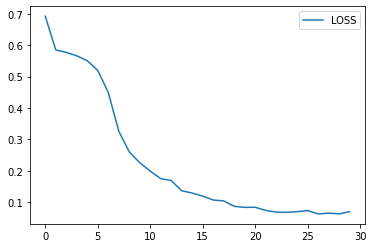

In [17]:
plt.plot(range(len(aggregator_loss)), aggregator_loss, label='LOSS')
plt.legend()
plt.show()

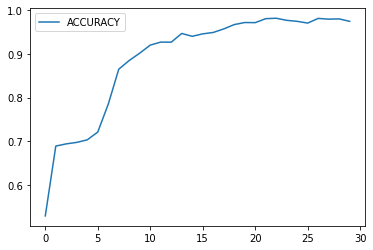

In [18]:
plt.plot(range(len(aggregator_accuracy)), aggregator_accuracy, label='ACCURACY')
plt.legend()
plt.show()

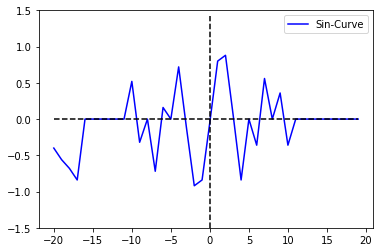

In [19]:
the_curve_generated_so_far(aggregator_model)